In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.chdir("../")
%pwd

'/Users/macbookpro/Documents/predict_publications/publications_prediction'

# EDA

In [3]:
def load_data(train_url, validation_url, test_url, sample_url):

    train_data = pd.read_csv(train_url)
    validation_data = pd.read_csv(validation_url)
    test_data = pd.read_csv(test_url)
    sample_train_data = pd.read_csv(sample_url)
    
    return train_data, validation_data, test_data, sample_train_data

In [4]:
def visualize_important_periods(data):


    # Extracting the publication count based on date
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    date_counts = data.groupby(data['timestamp'].dt.date).size()

    # Periods to be highlighted
    conference_seasons = ('2019-02-01', '2019-04-30', 'Conference Seasons')
    # covid_start = ('2020-03-01', '2020-05-31', 'Start of COVID')
    # covid_end = ('2021-06-01', '2021-08-31', 'End of COVID')
    paper_submissions = ('2019-10-01', '2019-11-30', 'Paper Submissions')

    important_periods = [conference_seasons, paper_submissions]

    # Plotting the publication data alongside the highlighted periods
    plt.figure(figsize=(15, 8))

    # Plotting the publication data
    plt.plot(date_counts.index, date_counts.values, label='Publication Count', color='blue')

    # Highlighting periods
    for period, color in zip(important_periods, ['red', 'green', 'yellow', 'purple']):
        start_date, end_date, label = period
        plt.axvspan(start_date, end_date, color=color, alpha=0.3, label=label)

    # Adding titles and labels
    plt.title('Publication Count Over Time with Highlighted Periods')
    plt.xlabel('Date')
    plt.ylabel('Publication Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
train_data, validation_data, test_data, sample_train_data = load_data('/Users/macbookpro/Documents/predict_publications/publications_prediction/data/train_data.csv',
                                                   '/Users/macbookpro/Documents/predict_publications/publications_prediction/data/validation_data.csv',
                                                  '/Users/macbookpro/Documents/predict_publications/publications_prediction/data/test_data.csv',
                                                   '/Users/macbookpro/Documents/predict_publications/publications_prediction/data/sampled_train_data.csv' )


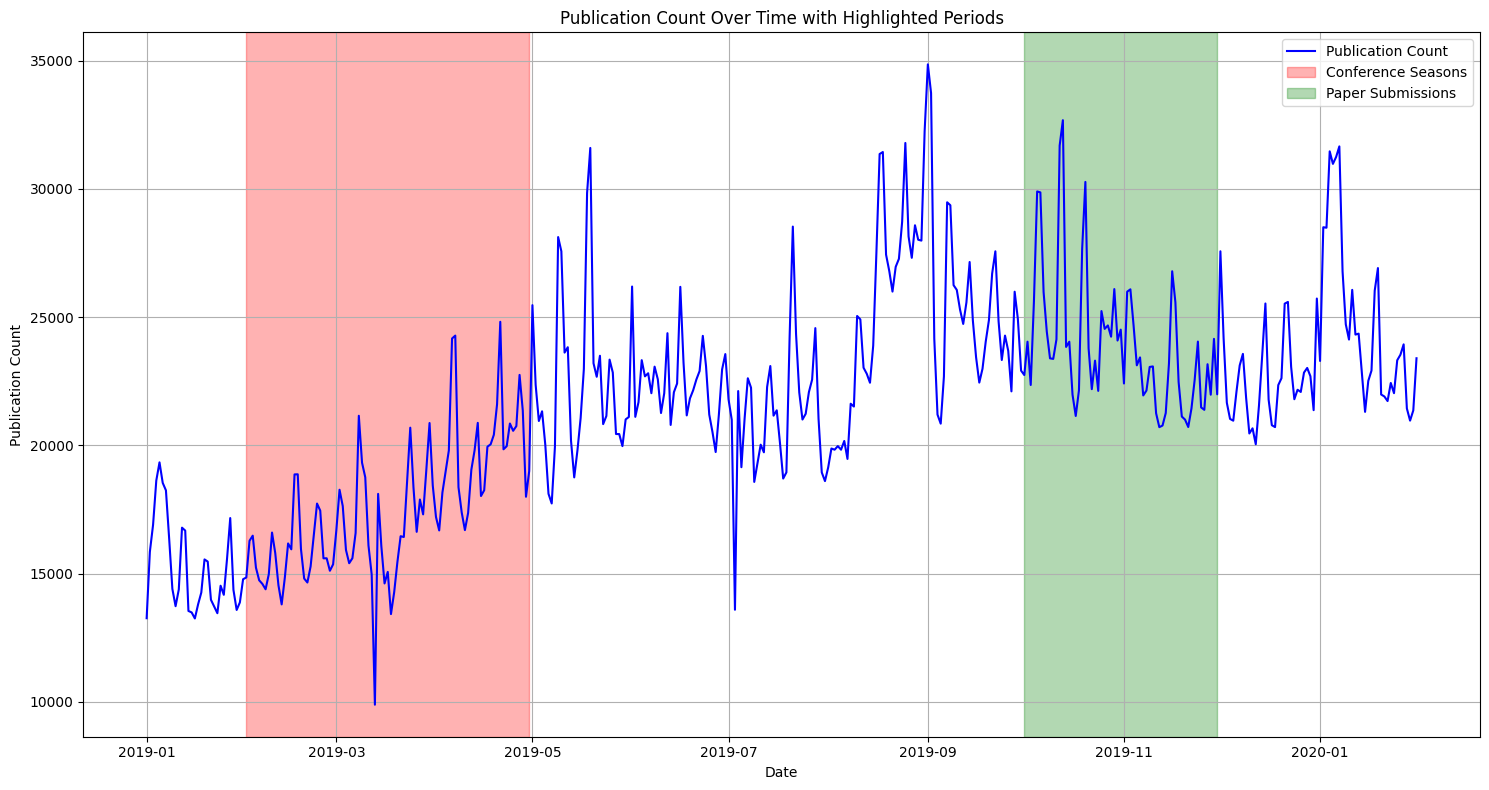

In [6]:
visualize_important_periods(train_data)

# # GRU via PyTorch

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

class GRUModel(nn.Module):
    """GRU-based model for predicting publications."""
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        """
        Initialize the GRU model.
        
        Parameters:
        - input_dim (int): Dimension of input data.
        - hidden_dim (int): Number of hidden neurons.
        - num_layers (int): Number of GRU layers.
        - output_dim (int): Dimension of output.
        """
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """Forward pass of the model."""
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class PublicationPredictor:
    def __init__(self, train_file_path, valid_file_path, test_file_path=None):
        """
        Initialize the PublicationPredictor class.

        Parameters:
        - train_file_path (str): Path to the training data file.
        - valid_file_path (str): Path to the validation data file.
        - test_file_path (str, optional): Path to the test data file. Defaults to None.
        """
        self.train_data = pd.read_csv(train_file_path)
        self.valid_data = pd.read_csv(valid_file_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load test data if provided
        if test_file_path:
            self.test_data = pd.read_csv(test_file_path)
        else:
            self.test_data = None

    def _preprocess_training_data(self):
        """Preprocess and aggregate training data."""
        self.train_data["timestamp"] = pd.to_datetime(self.train_data["timestamp"], unit="s")
        agg_train_data = (
            self.train_data.groupby(["timestamp", "lat", "lon", "point"])
            .size()
            .reset_index(name="num_publications")
        )
        # Extract temporal features
        agg_train_data["hour"] = agg_train_data["timestamp"].dt.hour
        agg_train_data["day_of_week"] = agg_train_data["timestamp"].dt.dayofweek
        agg_train_data["day"] = agg_train_data["timestamp"].dt.day
        agg_train_data["month"] = agg_train_data["timestamp"].dt.month
        
        agg_train_data.sort_values(by=["point", "timestamp"], inplace=True)
        agg_train_data["lag_1"] = agg_train_data.groupby("point")["num_publications"].shift(1)
        
        # Create tensors for training
        X_train = agg_train_data.drop(columns=["num_publications", "timestamp", "point"])
        y_train = agg_train_data["num_publications"]
        mask = X_train["lag_1"].notna()
        X_train = X_train[mask]
        y_train = y_train[mask]

        self.X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(self.device)
        self.y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(self.device)

    def _preprocess_test_data(self):
        """Preprocess and aggregate test data."""
        # Convert the "timestamp" column to datetime
        self.test_data["timestamp"] = pd.to_datetime(self.test_data["timestamp"], unit="s")
        
        
        # Derive the "hour" column from the "timestamp" column
        self.test_data["hour"] = self.test_data["timestamp"].dt.hour
        
        agg_test_data = (
        self.test_data.groupby(["timestamp", "lat", "lon", "point"])["num_of_publications"]
        .sum()
        .reset_index(name="num_publications")
)
        # Extract temporal features
        agg_test_data["hour"] = agg_test_data["timestamp"].dt.hour
        agg_test_data["day_of_week"] = agg_test_data["timestamp"].dt.dayofweek
        agg_test_data["day"] = agg_test_data["timestamp"].dt.day
        agg_test_data["month"] = agg_test_data["timestamp"].dt.month
        
        agg_test_data.sort_values(by=["point", "timestamp"], inplace=True)
        agg_test_data["lag_1"] = agg_test_data.groupby("point")["num_publications"].shift(1)
        
        # Create tensors for testing
        X_test = agg_test_data.drop(columns=["num_publications", "timestamp", "point"])
        y_test = agg_test_data["num_publications"]

        self.retained_mask = X_test.index

        self.mask_test = X_test["lag_1"].notna()
        X_test = X_test[self.mask_test]
        y_test = y_test[self.mask_test]
        
        self.X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(self.device)
        self.y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(self.device)

    def _preprocess_validation_data(self):
        """Preprocess and aggregate validation data."""
        self.valid_data["timestamp"] = pd.to_datetime(self.valid_data["timestamp"], unit="s")
        agg_valid_data = (
            self.valid_data.groupby(["timestamp", "lat", "lon", "point"])
            .size()
            .reset_index(name="sum")
        )
        # Extract temporal features
        agg_valid_data["hour"] = agg_valid_data["timestamp"].dt.hour
        agg_valid_data["day_of_week"] = agg_valid_data["timestamp"].dt.dayofweek
        agg_valid_data["day"] = agg_valid_data["timestamp"].dt.day
        agg_valid_data["month"] = agg_valid_data["timestamp"].dt.month
        
        agg_valid_data.sort_values(by=["point", "timestamp"], inplace=True)
        agg_valid_data["lag_1"] = agg_valid_data.groupby("point")["sum"].shift(1)
        
        # Create tensors for validation
        X_valid = agg_valid_data.drop(columns=["sum", "timestamp", "point"])
        y_valid = agg_valid_data["sum"]
        mask_valid = X_valid["lag_1"].notna()
        X_valid = X_valid[mask_valid]
        y_valid = y_valid[mask_valid]

        self.X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32).to(self.device)
        self.y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1).to(self.device)

    def preprocess_data(self):
        """Preprocess training, validation, and test data."""
        self._preprocess_training_data()
        self._preprocess_validation_data()
        if self.test_data is not None:
            self._preprocess_test_data()

    def define_model(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, lr=0.01, weight_decay=1e-5):
        """
        Define the GRU model, loss function, optimizer, and scheduler.

        Parameters:
        - input_dim (int): Dimension of input data.
        - hidden_dim (int, optional): Number of hidden neurons. Defaults to 64.
        - num_layers (int, optional): Number of GRU layers. Defaults to 2.
        - output_dim (int, optional): Dimension of output. Defaults to 1.
        - lr (float, optional): Learning rate for the optimizer. Defaults to 0.01.
        - weight_decay (float, optional): Weight decay for the optimizer. Defaults to 1e-5.
        """
        self.model = GRUModel(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            output_dim=output_dim,
        ).to(self.device)

        # Define loss, optimizer, and scheduler
        self.criterion = nn.MSELoss(reduction="mean")
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = StepLR(self.optimizer, step_size=10, gamma=0.7)

    def train(self, num_epochs=5, batch_size=1024):
        """
        Train the model on the provided training data.

        Parameters:
        - num_epochs (int, optional): Number of training epochs. Defaults to 5.
        - batch_size (int, optional): Training batch size. Defaults to 1024.
        """
        # DataLoader for training and validation
        train_dataset = TensorDataset(self.X_train_tensor, self.y_train_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

        valid_dataset = TensorDataset(self.X_valid_tensor, self.y_valid_tensor)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

        best_loss = float('inf')

        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0.0
            total_relative_error = 0.0  # To accumulate relative errors
            correct_predictions = 0

            loop = tqdm(train_loader, total=len(train_loader), leave=False)
            for batch_idx, (data, target) in enumerate(loop):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(data)

                predicted = torch.round(outputs)
                correct_predictions += (predicted == target).sum().item()
                
                # Calculate relative error for this batch and accumulate
                epsilon = 1e-10
                relative_error_batch = (torch.abs(outputs - target) / (outputs + epsilon)).sum().item()
                total_relative_error += relative_error_batch

                loss = self.criterion(outputs, target)
                total_loss += loss.item()
                loss.backward()
                self.optimizer.step()

                # Update tqdm progress bar
                loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
                loop.set_postfix(loss=loss.item())

            # Validate the model at the end of the epoch
            valid_loss = 0.0
            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    outputs = self.model(data)
                    loss = self.criterion(outputs, target)
                    valid_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            avg_relative_error = total_relative_error / len(self.y_train_tensor)
            accuracy = (correct_predictions / len(self.y_train_tensor)) * 100

            avg_valid_loss = valid_loss / len(valid_loader)

            # Check if this model has the lowest validation loss and save if so
            if avg_valid_loss < best_loss:
                best_loss = avg_valid_loss
                torch.save(self.model.state_dict(), 'best_model.pth')
            
            print(f"Epoch {epoch+1}/{num_epochs},Train Loss: {avg_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}, Average Relative Error: {avg_relative_error:.4f}, Accuracy: {accuracy:.2f}%")

    def test(self):
        """Evaluate and visualize model's performance on test data."""
        if self.test_data is None:
            print("No test data provided.")
            return
        
        # Preprocess test data
        self._preprocess_test_data()
        
        # Load best model
        self.model.load_state_dict(torch.load('best_model.pth'))
        self.model.eval()
        
        with torch.no_grad():
            predictions = self.model(self.X_test_tensor)

            # Calculate Average Relative Error based on predictions
            epsilon = 1e-10
            average_relative_error = (torch.abs(predictions - self.y_test_tensor) / (predictions + epsilon)).mean().item()
            print(f"Average Relative Error on Test Data: {average_relative_error:.4f}")

            # Create a mask for indexing the original dataframe
            retained_rows = self.test_data.loc[self.retained_mask]
            retained_rows = retained_rows[self.mask_test]

            # Plot results
            predictions_np = predictions.cpu().numpy().flatten()
            y_test_np = self.y_test_tensor.cpu().numpy().flatten()

            plt.figure(figsize=(15, 7))
            plt.scatter(retained_rows["hour"], predictions_np, label="Predictions", color="red", marker="o", s=5)
            plt.scatter(retained_rows["hour"], y_test_np, label="True Values", color="blue", alpha=0.5, marker=".", s=10)
            plt.xlabel("Time")
            plt.ylabel("Publications")
            plt.title("GRU Model Predictions vs True Values on Test Data")
            plt.legend()
            plt.grid(True)
            plt.show()


In [8]:
# Paths to your data files
train_file_path = "/Users/macbookpro/Documents/predict_publications/publications_prediction/data/train_data.csv"
valid_file_path = "/Users/macbookpro/Documents/predict_publications/publications_prediction/data/validation_data.csv"
test_file_path = "/Users/macbookpro/Documents/predict_publications/publications_prediction/data/test_data.csv"

# Initialize the PublicationPredictor class
predictor = PublicationPredictor(train_file_path, valid_file_path, test_file_path)

# Preprocess the data
predictor.preprocess_data()

# Define the model and hyperparameters
input_dim = predictor.X_train_tensor.shape[1]  # Number of input features
predictor.define_model(input_dim=input_dim)

# Train the model
predictor.train(num_epochs=10)

Epoch 1/10,Train Loss: 5.6309, Validation Loss: 0.2254, Average Relative Error: 0.4062, Accuracy: 37.17%


Epoch 2/10,Train Loss: 5.0129, Validation Loss: 0.2947, Average Relative Error: 0.4939, Accuracy: 34.23%


Epoch 3/10,Train Loss: 5.0177, Validation Loss: 0.4144, Average Relative Error: 0.4950, Accuracy: 35.32%


Epoch 4/10,Train Loss: 4.9619, Validation Loss: 0.3359, Average Relative Error: 0.4943, Accuracy: 34.97%


Epoch 5/10,Train Loss: 4.8988, Validation Loss: 0.1063, Average Relative Error: 0.4907, Accuracy: 37.42%


Epoch 6/10,Train Loss: 4.9245, Validation Loss: 0.3697, Average Relative Error: 0.4879, Accuracy: 38.67%


Epoch 7/10,Train Loss: 4.9397, Validation Loss: 0.1899, Average Relative Error: 0.4833, Accuracy: 41.47%


Epoch 8/10,Train Loss: 4.8436, Validation Loss: 0.1506, Average Relative Error: 0.4849, Accuracy: 39.98%


Epoch 9/10,Train Loss: 4.8139, Validation Loss: 0.2726, Average Relative Error: 0.4848, Accuracy: 38.12%


Epoch 10/10,Train Loss: 4.7722, Validation Loss: 0.3305, Average Relative Error: 0.4828, Accuracy: 41.85%


Average Relative Error on Test Data: 0.6540


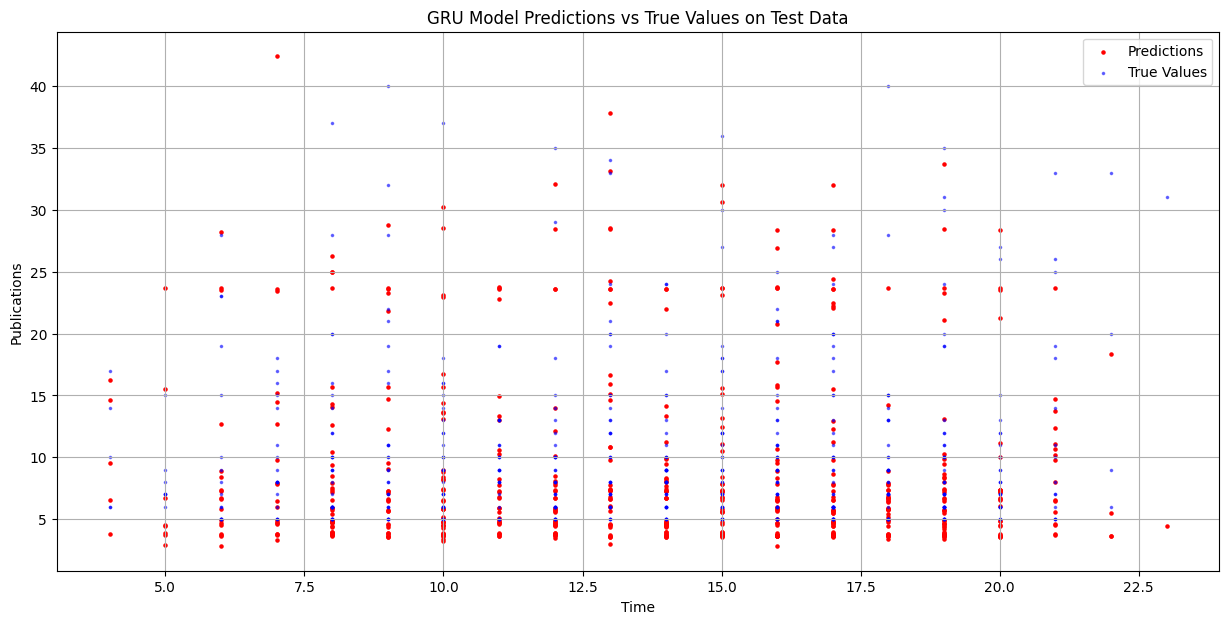

In [9]:
predictor.test()